# **Домашнее задание к семинару 06 (HW06)**

**Тема:** деревья решений и ансамбли (bagging / random forest / boosting / stacking) и честный ML-эксперимент.

**Цель** 

Закрепить:
- понимание того, как работает дерево решений и почему оно легко переобучается;
- навыки контроля сложности дерева (например, через max_depth, min_samples_leaf, ccp_alpha);
- практическое понимание ансамблей:
  - bagging как способ уменьшить variance;
  - Random Forest как bagging деревьев + случайность по признакам;
  - boosting как последовательное улучшение модели;
  - (опционально) stacking как композиция разных моделей через метамодель;
- постановку честного ML-эксперимента: фиксированный train/test, CV на train для подбора гиперпараметров, единые метрики, фиксация артефактов;
- аккуратное оформление результата в виде ноутбука + короткого отчёта.

### **1. Загрузка данных и первичный анализ**

**1.1. Импортировать необходимые библиотеки**

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.dummy import DummyClassifier
from sklearn.metrics import accuracy_score, f1_score, roc_auc_score
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.ensemble import StackingClassifier
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, roc_curve, auc
from sklearn.inspection import permutation_importance
from sklearn.metrics import precision_recall_curve, average_precision_score

import json
import os
import joblib

**1.2. Загрузить выбранный датасет**

In [3]:
url = "S06-hw-dataset-02.csv"
df = pd.read_csv(url)
print('Датасет успешно импортирован' if not df.empty else 'Датасет не импортирован')

Датасет успешно импортирован


**1.3. Выполнить первичный осмотр данных**

In [4]:
display(df.head())       # первые строки датасета
display(df.info())       # информация о столбцах и типах
display(df.describe())   # базовые описательные статистики

,id,f01,f02,f03,f04,f05,f06,f07,f08,f09,...,f29,f30,f31,f32,f33,f34,f35,x_int_1,x_int_2,target
0,1,-0.149235,-2.826966,-0.522901,-4.198449,1.364943,0.815043,-1.195518,-1.932232,2.396353,...,-0.159323,0.448015,0.572745,0.149916,0.878392,-0.679733,1.412751,0.421883,9.217167,1
1,2,-1.966180,-4.877542,0.268367,-9.607791,0.097149,1.347185,-3.872575,-0.395117,1.710068,...,-0.389212,1.383794,0.169876,0.043969,-0.963545,1.006643,-2.488690,9.590124,24.772826,0
2,3,-0.555964,-0.999920,0.209673,-14.119498,-1.808950,-0.006222,-4.651108,0.911944,-0.289037,...,-1.383970,3.044321,-0.182864,1.425649,-8.418598,-4.629754,-0.439798,0.555919,41.800517,0
3,4,-2.049199,-5.600713,-1.664677,-6.263893,-5.224455,0.848351,1.407210,-0.542080,0.119102,...,-2.713080,2.762637,-0.520796,-0.142455,1.668338,2.292810,-10.744916,11.476977,65.315860,0
4,5,-0.220556,4.889479,-2.235840,6.450046,0.774389,-2.382625,2.584816,4.211856,-0.317889,...,-1.302872,2.478862,1.528610,1.098131,3.547087,2.517757,-9.364106,-1.078404,93.017870,0


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 18000 entries, 0 to 17999
Data columns (total 39 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   id       18000 non-null  int64  
 1   f01      18000 non-null  float64
 2   f02      18000 non-null  float64
 3   f03      18000 non-null  float64
 4   f04      18000 non-null  float64
 5   f05      18000 non-null  float64
 6   f06      18000 non-null  float64
 7   f07      18000 non-null  float64
 8   f08      18000 non-null  float64
 9   f09      18000 non-null  float64
 10  f10      18000 non-null  float64
 11  f11      18000 non-null  float64
 12  f12      18000 non-null  float64
 13  f13      18000 non-null  float64
 14  f14      18000 non-null  float64
 15  f15      18000 non-null  float64
 16  f16      18000 non-null  float64
 17  f17      18000 non-null  float64
 18  f18      18000 non-null  float64
 19  f19      18000 non-null  float64
 20  f20      18000 non-null  float64
 21  f21      180

None

,id,f01,f02,f03,f04,f05,f06,f07,f08,f09,...,f29,f30,f31,f32,f33,f34,f35,x_int_1,x_int_2,target
count,18000.000000,18000.000000,18000.000000,18000.000000,18000.000000,18000.000000,18000.000000,18000.000000,18000.000000,18000.000000,...,18000.000000,18000.000000,18000.000000,18000.000000,18000.000000,18000.000000,18000.000000,18000.000000,1.800000e+04,18000.000000
mean,9000.500000,-0.418555,0.614251,0.004559,0.059000,0.405086,0.012123,-0.283473,-0.266880,0.255107,...,-0.139825,0.108568,0.007238,0.000904,-0.716862,-0.274520,0.344991,1.517339,2.576221e+01,0.262611
std,5196.296758,2.178005,3.926778,1.000134,5.713672,2.497581,0.987226,2.193891,2.081431,2.225776,...,2.148834,2.234315,0.997861,1.002115,3.913704,2.482890,4.927315,10.630850,5.423748e+01,0.440065
min,1.000000,-10.014698,-15.510323,-4.031762,-23.663256,-12.289308,-3.741536,-9.591425,-8.293319,-13.655742,...,-8.171469,-9.214171,-3.937091,-3.963063,-19.389908,-10.031559,-20.768452,-107.788145,1.895059e-07,0.000000
25%,4500.750000,-1.866134,-2.048192,-0.673127,-3.544964,-1.153000,-0.653090,-1.743214,-1.688121,-1.177480,...,-1.589638,-1.369266,-0.663023,-0.684164,-3.286842,-1.897893,-2.752685,-2.018750,1.226029e+00,0.000000
50%,9000.500000,-0.465100,0.600291,0.003581,0.072826,0.485625,0.018765,-0.251263,-0.302463,0.350739,...,-0.204785,0.158715,0.001912,-0.003157,-0.618472,-0.339901,0.573153,0.318011,6.581865e+00,0.000000
75%,13500.250000,0.966393,3.229850,0.671390,3.689490,2.075739,0.689304,1.195481,1.109589,1.764113,...,1.254595,1.600671,0.677296,0.676558,1.948803,1.314163,3.649794,4.212111,2.576847e+01,1.000000
max,18000.000000,9.589975,15.417329,3.817025,26.815691,10.665184,3.528280,7.794627,8.892834,8.699629,...,9.290667,8.794320,4.341030,3.781380,14.065595,10.639974,20.226291,94.891804,1.103449e+03,1.000000


In [5]:
print("\nРаспределение целевого признака 'target':")
print(df['target'].value_counts(normalize=True)) # соотношение классов


Распределение целевого признака 'target':
target
0    0.737389
1    0.262611
Name: proportion, dtype: float64


***Первичный осмотр данных показал:***
1. *Размер данных: 18000 строк и 39 признаков.*
2. *Пропусков нет.*
3. *Целевая переменная бинарная.*
4. *Баланс классов: `target`=1 около 26%, `target`=0 около 74%.*

### **2. Train/Test-сплит и воспроизводимость**

**2.1. Разделить данные на train/test**

In [6]:
X = df.drop(columns=["target", "id"])
y = df["target"]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=666, stratify=y)

**2.2. Коротко пояснить, почему фиксированный seed и стратификация важны**

*Фиксированный seed (или `random_state`) используется, чтобы метрики не менялись от запуска к запуску.*

*Стратификация по целевой переменной необходима для сохранения того же процентного состава классов и адекватной оценки модели, соответственно.*

### **3. Baseline-модели**

**3.1. Сделать минимум два baseline’а:**
- DummyClassifier (например, most_frequent или stratified).
- LogisticRegression (желательно через Pipeline(StandardScaler + LogisticRegression)).

Для обоих baseline’ов посчитать метрики на test (см. ниже) и кратко интерпретировать.

In [32]:
def eval_test_only(model, X_test, y_test):
    return {
        "accuracy": accuracy_score(y_test, model.predict(X_test)),
        "f1": f1_score(y_test, model.predict(X_test)),
        "roc_auc": roc_auc_score(
            y_test,
            model.predict_proba(X_test)[:, 1]
        )
    }

**DummyClassifier**

In [33]:
dummy = DummyClassifier(strategy="most_frequent")
dummy.fit(X_train, y_train)

dummy_metrics = eval_test_only(dummy, X_test, y_test)

print("DummyClassifier metrics:")
pd.DataFrame([dummy_metrics]).round(4)

DummyClassifier metrics:


,accuracy,f1,roc_auc
0,0.7373,0.0,0.5


**LogisticRegression**

In [34]:
logreg = Pipeline([
    ("scaler", StandardScaler()),
    ("logreg", LogisticRegression(max_iter=1000, random_state=666))
])

logreg.fit(X_train, y_train)

logreg_metrics = eval_test_only(logreg, X_test, y_test)

print("LogisticRegression metrics:")
pd.DataFrame([logreg_metrics]).round(4)

LogisticRegression metrics:


,accuracy,f1,roc_auc
0,0.8138,0.568,0.8065


*DummyClassifier предсказывает доминирующий класс, что приводит к нулевому значению f1 и ROC-AUC = 0.5, что отражает отсутствие способности различать классы.*

*Логистическая регрессия значительно превосходит бейзлайн по accuracy, f1 и ROC-AUC, что указывает на эффективное использование признаков и корректное разделение классов.*

### **4. Модели недели 6 (обязательно)**

Реализовать и сравнить минимум 3 модели недели 6 (рекомендуется 4):
- DecisionTreeClassifier

    Обязательно показать контроль сложности (например, max_depth + min_samples_leaf; или ccp_alpha).

- RandomForestClassifier

    Желательно посмотреть хотя бы одну из "лесных" ручек (max_features, min_samples_leaf, max_depth).

- Один boosting на выбор:
  - AdaBoostClassifier или
  - GradientBoostingClassifier или
  - HistGradientBoostingClassifier

- (Опционально) StackingClassifier (2-3 базовых модели + метамодель).

    Важно: делать стекинг корректно (через CV-логику; StackingClassifier в sklearn это делает).

Подбор гиперпараметров:
- выполнять только на train через CV (GridSearchCV или аккуратный перебор);
- test использовать один раз для финальной оценки.

**DecisionTreeClassifier**

**дерево без контроля сложности**

In [47]:
dt_base = DecisionTreeClassifier(random_state=666)
dt_base.fit(X_train, y_train)

dtnc_metrics = eval_test_only(dt_base, X_test, y_test)
dtnc_metrics.update({
    "train_roc_auc": roc_auc_score(y_train, dt_base.predict_proba(X_train)[:, 1])
})

print("DecisionTree (no control) metrics:")
pd.DataFrame([dtnc_metrics]).round(4)

DecisionTree (no control) metrics:


,accuracy,f1,roc_auc,train_roc_auc
0,0.8133,0.6468,0.761,1.0


**дерево с контролем сложности max_depth и min_samples_leaf**

In [48]:
dt_search = GridSearchCV(
    DecisionTreeClassifier(random_state=666),
    param_grid={
        "max_depth": [3, 5, 7, 10],
        "min_samples_leaf": [1, 5, 10, 20]
    },
    cv=5,
    scoring="roc_auc",
    n_jobs=-1
)

dt_search.fit(X_train, y_train)
dt_best = dt_search.best_estimator_

dt_metrics = eval_test_only(dt_best, X_test, y_test)
dt_metrics.update({
    "train_roc_auc": roc_auc_score(y_train, dt_best.predict_proba(X_train)[:, 1]),
    "best_max_depth": dt_search.best_params_["max_depth"],
    "best_min_samples_leaf": dt_search.best_params_["min_samples_leaf"]
})

print("DecisionTree (control) metrics:")
pd.DataFrame([dt_metrics]).round(4)

DecisionTree (control) metrics:


,accuracy,f1,roc_auc,train_roc_auc,best_max_depth,best_min_samples_leaf
0,0.8351,0.648,0.8377,0.928,10,20


*Без ограничений дерево показывает сильное переобучение (ROC-AUC = 1.0 на `train` и существенно ниже на `test`).
После введения ограничений `max_depth` и `min_samples_leaf` разрыв между `train` и `test` уменьшается, а качество на тестовой выборке улучшается, что свидетельствует о снижении переобучения.*

**RandomForestClassifier**

In [42]:
rf = RandomForestClassifier(
    n_estimators=200,
    random_state=666,
    n_jobs=-1
)

rf_param_grid = {
    "max_depth": [5, 10],
    "min_samples_leaf": [1, 5, 10],
    "max_features": ["sqrt", "log2"]
}

rf_search = GridSearchCV(
    rf,
    param_grid=rf_param_grid,
    cv=5,
    scoring="roc_auc",
    n_jobs=-1
)

rf_search.fit(X_train, y_train)
rf_best = rf_search.best_estimator_

rf_metrics = eval_test_only(rf_best, X_test, y_test)
rf_metrics.update(rf_search.best_params_)

print("RandomForest metrics:")
pd.DataFrame([rf_metrics]).round(4)

RandomForest metrics:


,accuracy,f1,roc_auc,max_depth,max_features,min_samples_leaf
0,0.8678,0.6844,0.9167,10,sqrt,5


**GradientBoostingClassifier**

In [43]:
gb = GradientBoostingClassifier(random_state=666)

gb_param_grid = {
    "n_estimators": [100, 200],
    "learning_rate": [0.05, 0.1],
    "max_depth": [2, 3],
    "min_samples_leaf": [5, 10]
}

gb_search = GridSearchCV(
    gb,
    param_grid=gb_param_grid,
    cv=5,
    scoring="roc_auc",
    n_jobs=-1
)

gb_search.fit(X_train, y_train)
gb_best = gb_search.best_estimator_

gb_metrics = eval_test_only(gb_best, X_test, y_test)

print("GradientBoosting metrics:")
pd.DataFrame([gb_metrics]).round(4)

GradientBoosting metrics:


,accuracy,f1,roc_auc
0,0.8867,0.7539,0.9132


**StackingClassifier**

In [44]:
stack = StackingClassifier(
    estimators=[
        ("rf", rf_best),
        ("gb", gb_best)
    ],
    final_estimator=LogisticRegression(max_iter=1000),
    cv=5,
    n_jobs=-1
)

stack.fit(X_train, y_train)

stack_metrics = eval_test_only(stack, X_test, y_test)

print("StackingClassifier metrics:")
pd.DataFrame([stack_metrics]).round(4)

StackingClassifier metrics:


,accuracy,f1,roc_auc
0,0.8947,0.7799,0.9183


In [63]:
# предсказания для построения графиков
y_pred_stack = stack.predict(X_test)
y_proba_stack = stack.predict_proba(X_test)[:, 1]

### **5. Метрики качества (обязательно)**

In [49]:
artifacts_path = r"D:\Projects\aiengine\homeworks\HW06\artifacts"
figures_path = os.path.join(artifacts_path, "figures")
os.makedirs(figures_path, exist_ok=True)

**5.1. Сохранение метрик всех моделей в JSON**

In [50]:
all_metrics = {
    "DummyClassifier": dummy_metrics,
    "LogisticRegression": logreg_metrics,
    "DecisionTreeClassifier (base)": dtnc_metrics,
    "DecisionTreeClassifier (best)": dt_metrics,
    "RandomForestClassifier": rf_metrics,
    "GradientBoostingClassifier": gb_metrics,
    "StackingClassifier": stack_metrics
}

metrics_file = os.path.join(artifacts_path, "metrics_test.json")
with open(metrics_file, "w") as f:
    json.dump(all_metrics, f, indent=4, ensure_ascii=False)
print(f"Метрики всех моделей сохранены в {metrics_file}")

Метрики всех моделей сохранены в D:\Projects\aiengine\homeworks\HW06\artifacts\metrics_test.json


**5.2. Сохранение результатов подбора гиперпараметров (GridSearchCV)**

In [51]:
search_summaries = {
    "DecisionTreeClassifier": {
        "best_params": dt_search.best_params_,
        "best_score": dt_search.best_score_
    },
    "RandomForestClassifier": {
        "best_params": rf_search.best_params_,
        "best_score": rf_search.best_score_
    }
}

search_file = os.path.join(artifacts_path, "search_summaries.json")
with open(search_file, "w") as f:
    json.dump(search_summaries, f, indent=4, ensure_ascii=False)
print(f"Результаты GridSearchCV сохранены в {search_file}")

Результаты GridSearchCV сохранены в D:\Projects\aiengine\homeworks\HW06\artifacts\search_summaries.json


**5.3. Сохранение лучшей модели и метаданных (StackingClassifier)**

In [52]:
best_model = stack
best_model_file = os.path.join(artifacts_path, "best_model.joblib")
joblib.dump(best_model, best_model_file)
print(f"Лучшая модель сохранена в {best_model_file}")

best_model_meta = {
    "model_name": "StackingClassifier",
    "metrics": stack_metrics,
    "best_params": {
        "DecisionTreeClassifier": dt_search.best_params_,
        "RandomForestClassifier": rf_search.best_params_
    }
}
meta_file = os.path.join(artifacts_path, "best_model_meta.json")
with open(meta_file, "w") as f:
    json.dump(best_model_meta, f, indent=4, ensure_ascii=False)
print(f"Метаданные лучшей модели сохранены в {meta_file}")

Лучшая модель сохранена в D:\Projects\aiengine\homeworks\HW06\artifacts\best_model.joblib
Метаданные лучшей модели сохранены в D:\Projects\aiengine\homeworks\HW06\artifacts\best_model_meta.json


**5.4. ROC-AUC- и PR-кривые**

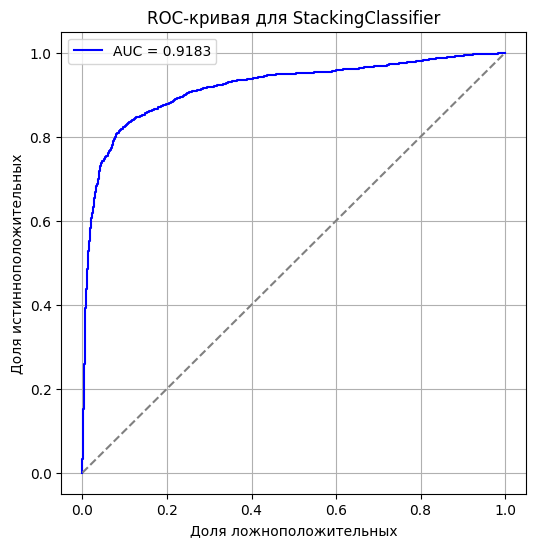

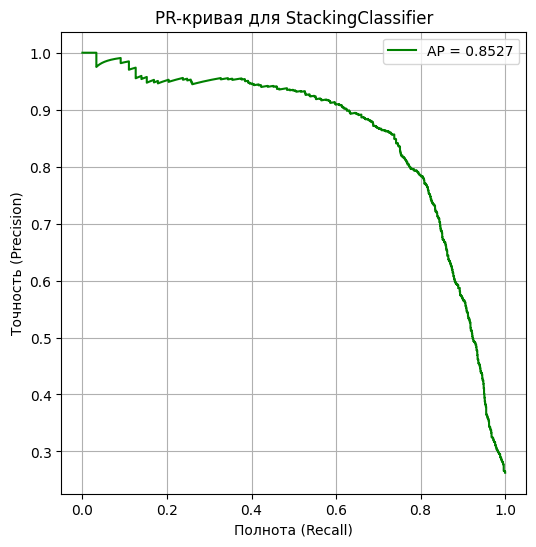

In [61]:
fpr, tpr, _ = roc_curve(y_test, y_proba_stack)
roc_auc_val = auc(fpr, tpr)

plt.figure(figsize=(6,6))
plt.plot(fpr, tpr, color='blue', label=f'AUC = {roc_auc_val:.4f}')
plt.plot([0,1], [0,1], color='gray', linestyle='--')
plt.xlabel('Доля ложноположительных')
plt.ylabel('Доля истинноположительных')
plt.title('ROC-кривая для StackingClassifier')
plt.legend()
plt.grid(True)
plt.savefig(os.path.join(figures_path, "roc_curve_stacking.png"))
plt.show()

precision, recall, _ = precision_recall_curve(y_test, y_proba_stack)
ap_score = average_precision_score(y_test, y_proba_stack)

plt.figure(figsize=(6,6))
plt.plot(recall, precision, color='green', label=f'AP = {ap_score:.4f}')
plt.xlabel('Полнота (Recall)')
plt.ylabel('Точность (Precision)')
plt.title('PR-кривая для StackingClassifier')
plt.legend()
plt.grid(True)
plt.savefig(os.path.join(figures_path, "pr_curve_stacking.png"))
plt.show()

**5.5. Матрица ошибок**

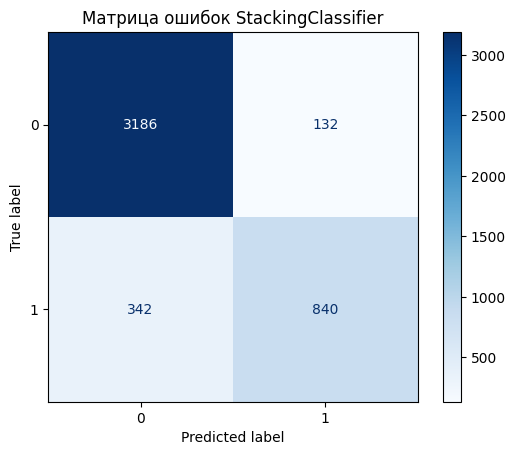

In [62]:
cm = confusion_matrix(y_test, y_pred_stack)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot(cmap=plt.cm.Blues)
plt.title("Матрица ошибок StackingClassifier")
plt.savefig(os.path.join(figures_path, "confusion_matrix_stacking.png"))
plt.show()

### **6. Интерпретация (обязательно)**

Для лучшей модели (по согласованному критерию – например, ROC-AUC на бинарных задачах или f1_macro на мультиклассе):
- посчитать permutation importance (top-10/15 признаков);
- кратко интерпретировать: какие признаки влияют сильнее и насколько это похоже на ожидания по данным.

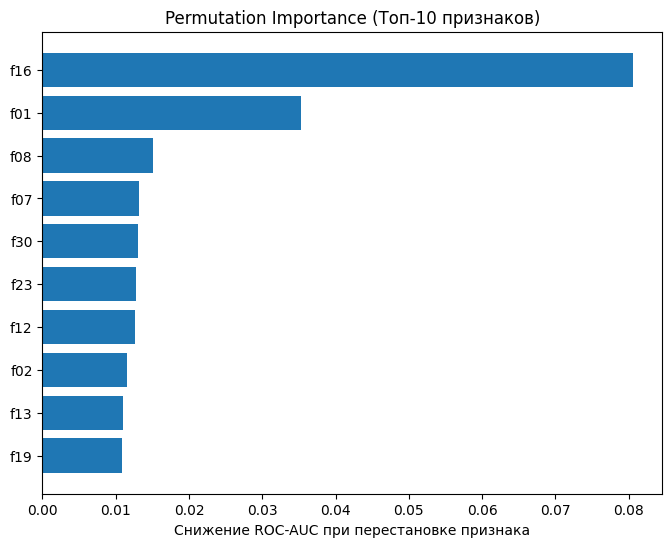

In [57]:
perm_importance = permutation_importance(
    best_model, X_test, y_test, n_repeats=10, random_state=666, n_jobs=-1
)
sorted_idx = perm_importance.importances_mean.argsort()[::-1][:10]

plt.figure(figsize=(8,6))
plt.barh(range(len(sorted_idx)), perm_importance.importances_mean[sorted_idx], align='center')
plt.yticks(range(len(sorted_idx)), [X_train.columns[i] for i in sorted_idx])
plt.xlabel("Снижение ROC-AUC при перестановке признака")
plt.title("Permutation Importance (Топ-10 признаков)")
plt.gca().invert_yaxis()
plt.savefig(os.path.join(figures_path, "permutation_importance_stacking.png"))
plt.show()

*Наибольшее влияние на предсказания оказывают признаки `f16` и `f01`. Модель соответствует ожидаемому распределению важности по данным.*